In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous
from scipy.stats import f
from prettytable import PrettyTable


class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [2]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  }
  real myBetaPrior_lpdf(real x, real beta) {
      return -log(beta); // log(1/beta) = log(1) - log(beta) = - log(beta)
  }
}
data { 
  int N;
  real y[N]; // points sampled from gpd in python with some(known) parameters, by mcmc we recover true values of those params
}
parameters { 
  real alpha;
  real beta;
}
model {
  // Priors; no priors - we assume improper priors on params
  alpha ~ gamma(1,1);
  beta ~ gamma(1,1);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }
}
generated quantities{}
"""

In [3]:
Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
}
data { 
  int N;
  real y[N]; 
}
parameters { 
  //parameters of the Fisher
  real<lower=0> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta; 
}
model {
  // when we deliberately do not specify priors then Stan works with improper priors
  alpha1 ~ gamma(1,1);
  alpha2 ~ gamma(1,1);
  beta ~ gamma(1,1);
   // Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}
generated quantities{}
"""

In [4]:
q = [0.98, 0.99, 0.995, 0.999, 0.9995]
beta = 1/2
quant_th = np.zeros(len(q))
for i in range(len(q)):
    quant_th[i] = pow(-log(q[i]), -beta)

def quantiles_GPD(excesses, k, u): 
    """ 
    we forward to function array of the quantiles as excesses, the number of excesses, k, and the border value u
    """
    quant_GPD = np.zeros(len(q)) 
    bayesian_quant_GPD = np.zeros(len(q))

    # here we fit GPD to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=GPD).sampling(data=data,iter=1000,warmup=200, chains=1) 
    
    # we save the params from the fit to calculate GPD quantiles and their traceplots to calculate Bayesian GPD quantiles
    traceplot_beta_GPD = list(fit.extract().values())[1].tolist() 
    traceplot_alpha = list(fit.extract().values())[0].tolist()
    traceplot_gamma = np.divide(np.ones(len(traceplot_alpha)), traceplot_alpha)
    beta_GPD = np.mean(list(fit.extract().values())[1].tolist())
    alpha = np.mean(list(fit.extract().values())[0].tolist())
    gamma = 1 / alpha 
    
    for i in range(len(q)):
        quant_GPD[i] = u + beta_GPD*( pow( N * (1-q[i]) / k, -gamma ) - 1 ) 
        for j in range(len(traceplot_gamma)):
                bayesian_quant_GPD[i] += u + traceplot_beta_GPD[j] * (pow( N * (1 - q[i]) / k, - traceplot_gamma[j] ) - 1)
    bayesian_quant_GPD = bayesian_quant_GPD / len(traceplot_gamma)
    list_of_params = [alpha, beta_GPD]
    return(quant_GPD, bayesian_quant_GPD, list_of_params ) # it return arrays: quant_GPD, bayesian_quant_GPD and values alpha, beta_GPD

def quantiles_Fisher(excesses, k, u):
    quant_Fisher = np.zeros(len(q)) 
    bayesian_quant_Fisher = np.zeros(len(q))
    
    # here we fit GPD to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=1000,warmup=200, chains=1) 
    
    # we save the params from the fit to calculate Fisher quantiles and their traceplots to calculate Bayesian Fisher quantiles
    traceplot_beta = list(fit.extract().values())[2].tolist()
    traceplot_alpha1 = list(fit.extract().values())[1].tolist()
    traceplot_alpha2 = list(fit.extract().values())[0].tolist()
    beta = np.mean(list(fit.extract().values())[2].tolist())
    alpha2 = np.mean(list(fit.extract().values())[1].tolist())
    alpha1 = np.mean(list(fit.extract().values())[0].tolist())
    beta0 = alpha2/alpha1
    
    for i in range(len(q)):
        quant_Fisher[i] = u + beta0 / beta * f.isf(N / k * (1-q[i]), 2 * alpha1, 2 * alpha2, loc=0, scale=1)
        for j in range(len(traceplot_alpha1)):
                bayesian_quant_Fisher[i] += u + traceplot_alpha2[j] / traceplot_alpha1[j] / traceplot_beta[j] * f.isf(N / k *(1- q[i]), 2 * traceplot_alpha1[j], 2 * traceplot_alpha2[j], loc=0, scale=1)
    bayesian_quant_Fisher = bayesian_quant_Fisher / len(traceplot_alpha1)
    list_of_params = [alpha1, alpha2, beta]
    return(quant_Fisher, bayesian_quant_Fisher, list_of_params) 
# it return arrays: quant_Fisher, bayesian_quant_Fisher and values of params as a list


In [5]:
def plot_table(k, averaged_bayesian_quant_Fisher, averaged_quant_Fisher, averaged_bayesian_quant_GPD, averaged_quant_GPD):
    m = "3" # how much we round
    rounding = "%." + m + "f"
    m = int(m)
    t_quantiles = PrettyTable(["# of excesses k = " +  str(k),  
                               'mean', 
                               'sd',
                               str(q[0] * 100) + "%", 
                               str(q[1] * 100) + "%",
                               str(q[2] * 100) + "%",
                               str(q[3] * 100) + "%",
                               str(q[4] * 100) + "%"])
    t_quantiles.add_row(['theoretically', '--', '--',
                         rounding % round(quant_th[0],m),  
                         rounding % round(quant_th[1], m), 
                         rounding % round(quant_th[2], m),
                         rounding % round(quant_th[3], m),
                         rounding % round(quant_th[4], m) ])
    t_quantiles.add_row(['Bayes Fisher',  '--', '--',
                         rounding % round(averaged_bayesian_quant_Fisher[0],m),  
                         rounding % round(averaged_bayesian_quant_Fisher[1], m), 
                         rounding % round(averaged_bayesian_quant_Fisher[2], m),
                         rounding % round(averaged_bayesian_quant_Fisher[3], m),
                         rounding % round(averaged_bayesian_quant_Fisher[4], m) ])
    t_quantiles.add_row(['Fisher',  '--', '--',
                         rounding % round(averaged_quant_Fisher[0],m),  
                         rounding % round(averaged_quant_Fisher[1], m), 
                         rounding % round(averaged_quant_Fisher[2], m),
                         rounding % round(averaged_quant_Fisher[3], m),
                         rounding % round(averaged_quant_Fisher[4], m) ])
    t_quantiles.add_row(['Bayes GPD', '--', '--',
                         rounding % round(averaged_bayesian_quant_GPD[0],m),  
                         rounding % round(averaged_bayesian_quant_GPD[1], m), 
                         rounding % round(averaged_bayesian_quant_GPD[2], m),
                         rounding % round(averaged_bayesian_quant_GPD[3], m),
                         rounding % round(averaged_bayesian_quant_GPD[4], m) ])
    t_quantiles.add_row(['GPD',  '--', '--',
                         rounding % round(averaged_quant_GPD[0],m),  
                         rounding % round(averaged_quant_GPD[1], m), 
                         rounding % round(averaged_quant_GPD[2], m),
                         rounding % round(averaged_quant_GPD[3], m),
                         rounding % round(averaged_quant_GPD[4], m) ])
    return(print(t_quantiles))

In [6]:
def plot_variability(jump_excesses, method, quantile_level, title):
    plt.plot(jump_excesses, method )
    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(quantile_level))
    plt.title('Variability of quantile at level ' + str(quantile_level) + ' obtained with: ' + title )
    return(plt.show())

In [7]:
def k_greatest_values_matrices(a,k):
    """returns k greatest elements from the list a and k - 1 value starting from which we consider greater values as extremes"""
    # we prepare the matrix for the excesses, the last value of 1 could be substituted by any value within the range
    mat = np.zeros( len(a[-1 - k + 1 : , 1] ) ) 
    # we prepare the vector in which we will return u values for each dataset in column of a
    u = np.zeros(len(r[0 , : ] )) 
    for i in range(len(a[0,:])): 
        # index i goes through the columns, instead of len(a[0,:]) there could be len(a[i,:]) for i in range of columns
        u[i] = a[-1 - k, i] 
        # u is a list of values s.t. bigger values are considered as excesses, for each set of data, i.e. for each column we save an u value
        mat = np.column_stack( (mat,a[ -1 - k + 1 : , i]) ) 
    # in mat matrix we return the values of excesses but not yet transformed (y_i = x_i - u)
    return(mat, u) # u is the starting value from which we consider others as excesses

In [22]:
n = 20 # number of sampled dataset over which we average the quantiles
N, beta = 1000,  1/2

r = frechet.rvs(beta, size=N)
for i in range(n):
    r = np.column_stack( (r, frechet.rvs(beta, size=N) ) ) 

# we need to sort in increasing order sampled data
for i in range(len(r[0,:])):
    r[:,i] = np.sort(r[:,i], axis=None)

In [33]:
how_many_different_thresholds = 20
min_thresholds = 50
max_thresholds = N / 2
# astype function converts the values in the array to integers
jump_excesses = np.linspace(min_thresholds, max_thresholds, how_many_different_thresholds).astype(int) 

number_of_GPD_params = 2
number_of_Fisher_params = 3

averaged_params_GPD, averaged_params_Fisher =  np.zeros(number_of_GPD_params), np.zeros(number_of_Fisher_params)


# we initialize the matrices of quantiles with row of zeros
concatenated_averaged_quant_GPD, concatenated_averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
concatenated_averaged_quant_Fisher, concatenated_averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))

counter = 0 # counter to normalize over the values of parameters

for j in range(len(jump_excesses)): # for different threshold of excesses
    k = jump_excesses[j]
    
    # in data frechet we keep the matrix of excesses
    # transferred r is a matrix with n sampled dataset from Frechet
    
    data_frechet, u = k_greatest_values_matrices(r,k) 

    # delete first column (indexed by 0) of a matrix A, to match the sizes 
    A = np.delete(data_frechet, 0, 1)

    # form the array of u values we create matrix, in columns we have repeated u values   
    B = [ [x] * k for x in u ] 

    # here we subtract u_i from excesses in each dataset
    C = np.array(A) - np.array(B).transpose() 
#     counter = counter +  1
    averaged_quant_GPD, averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
    averaged_quant_Fisher, averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))

    for i in range(n): 
        counter = counter +  1

        # we fit GPD and Fisher distributions to excesses from each dataset
        excesses_array = C[:,i] # asarray(C.transpose().tolist()[i]) 
        quant_GPD, bayesian_quant_GPD, params_GPD = quantiles_GPD(excesses_array, k, u[i])
        quant_Fisher, bayesian_quant_Fisher, params_Fisher = quantiles_Fisher(excesses_array, k, u[i])
        print("\n quant_Fisher : \n ", quant_Fisher,"\n bayesian_quant_Fisher: \n", bayesian_quant_Fisher)
        averaged_quant_GPD += quant_GPD
        averaged_bayesian_quant_GPD += bayesian_quant_GPD
        averaged_params_GPD += params_GPD 
        print("\n averaged_quant_GPD \n ", averaged_quant_GPD, "\n averaged_bayesian_quant_GPD \n", averaged_bayesian_quant_GPD)
        
        averaged_quant_Fisher += quant_Fisher
        print("\n averaged_quant_Fisher: \n", averaged_quant_Fisher)
        averaged_bayesian_quant_Fisher += bayesian_quant_Fisher
        print("\n averaged_bayesian_quant_Fisher: \n", averaged_bayesian_quant_Fisher)
        averaged_params_Fisher += params_Fisher 

        
    print("\n counter: \n", counter)    
    averaged_quant_GPD = averaged_quant_GPD / n 
    averaged_bayesian_quant_GPD = averaged_bayesian_quant_GPD / n
    averaged_params_GPD = asarray(averaged_params_GPD) / n

    averaged_quant_Fisher = averaged_quant_Fisher / n 
    averaged_bayesian_quant_Fisher = averaged_bayesian_quant_Fisher / n
    averaged_params_Fisher = asarray(averaged_params_Fisher) / n
    
    print("quant_Fisher \n ",averaged_quant_Fisher, "bayesian_quant_Fisher \n ", averaged_bayesian_quant_Fisher )
    
    plot_table(jump_excesses[j], 
           averaged_bayesian_quant_Fisher, 
           averaged_quant_Fisher, 
           averaged_bayesian_quant_GPD, 
           averaged_quant_GPD)
    
    print(" Current number of excesses k = " + str(jump_excesses[j]), 
          "\n", "averaged_params_GPD: ", averaged_params_GPD, 
          "\n", "averaged_params_Fisher: ", averaged_params_Fisher)
    
    #preparing to plot
    
    concatenated_averaged_quant_GPD = np.column_stack( (concatenated_averaged_quant_GPD, averaged_quant_GPD ) )
    concatenated_averaged_bayesian_quant_GPD = np.column_stack( (concatenated_averaged_bayesian_quant_GPD, averaged_bayesian_quant_GPD ) )
    concatenated_averaged_quant_Fisher = np.column_stack( (concatenated_averaged_quant_Fisher, averaged_quant_Fisher ) )
    concatenated_averaged_bayesian_quant_Fisher = np.column_stack( (concatenated_averaged_bayesian_quant_Fisher, averaged_bayesian_quant_Fisher ) )

# we delete first column which was created as zeros
concatenated_averaged_quant_GPD = np.delete(concatenated_averaged_quant_GPD, 0, 1)
concatenated_averaged_bayesian_quant_GPD = np.delete(concatenated_averaged_bayesian_quant_GPD, 0, 1)
concatenated_averaged_quant_Fisher = np.delete(concatenated_averaged_quant_Fisher, 0, 1)
concatenated_averaged_bayesian_quant_Fisher = np.delete(concatenated_averaged_bayesian_quant_Fisher, 0, 1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.54651655  6.70300101  8.86302104 24.13918097 41.54756771] 
 bayesian_quant_Fisher: 
 [nan nan nan nan nan]

 averaged_quant_GPD 
  [  7.26669724  11.00719204  17.76352811  62.36447917 110.52855243] 
 averaged_bayesian_quant_GPD 
 [  7.29928086  11.41085312  19.70904976  95.82194516 211.24851524]

 averaged_quant_Fisher: 
 [ 5.54651655  6.70300101  8.86302104 24.13918097 41.54756771]

 averaged_bayesian_quant_Fisher: 
 [nan nan nan nan nan]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.35984567  7.05755766 10.28851346 33.81334839 61.20515712] 
 bayesian_quant_Fisher: 
 [nan nan nan nan nan]

 averaged_quant_GPD 
  [ 13.26571075  19.71469131  31.63343847 113.93377644 206.09363939] 
 averaged_bayesian_quant_GPD 
 [ 13.30821325  20.34847316  34.82054967 171.91950852 383.79426208]

 averaged_quant_Fisher: 
 [ 10.90636222  13.76055867  19.1515345   57.95252936 102.75272483]

 averaged_bayesian_quant_Fisher: 
 [nan nan nan nan nan]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 4.84328612  5.39674045  6.18089302  9.58792075 12.21888926] 
 bayesian_quant_Fisher: 
 [ 5.14294805  5.98321998  7.15261145 12.17577448 16.09783854]

 averaged_quant_GPD 
  [ 20.12753741  29.66467566  46.13075673 149.06343055 257.66819831] 
 averaged_bayesian_quant_GPD 
 [ 20.21579495  30.55440318  50.17639427 214.45483726 451.87761929]

 averaged_quant_Fisher: 
 [ 15.74964834  19.15729912  25.33242752  67.54045011 114.97161409]

 averaged_bayesian_quant_Fisher: 
 [nan nan nan nan nan]

 counter: 
 3
quant_Fisher 
  [ 5.24988278  6.38576637  8.44414251 22.51348337 38.32387136] bayesian_quant_Fisher 
  [nan nan nan nan nan]
+----------------------+------+----+-------+--------+--------+--------+---------+
| # of excesses k = 50 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  |  99.95% |
+----------------------+------+----+-------+--------+--------+--------+---------+
|    theoretically     |  --  | -- | 7.036 | 9.975  | 14.124 | 31.615 |  44.716 |
|     Bayes Fisher 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.04291353  6.28610452  8.35258765 20.10110361 31.38531768] 
 bayesian_quant_Fisher: 
 [ 5.8885594   7.94744842 11.27875133 30.1105958  48.8247884 ]

 averaged_quant_GPD 
  [ 7.59649534 11.44086802 17.55435412 49.44540579 77.99079789] 
 averaged_bayesian_quant_GPD 
 [  7.66190408  11.80369356  18.79868894  61.27981541 105.7038917 ]

 averaged_quant_Fisher: 
 [ 5.04291353  6.28610452  8.35258765 20.10110361 31.38531768]

 averaged_bayesian_quant_Fisher: 
 [ 5.8885594   7.94744842 11.27875133 30.1105958  48.8247884 ]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.59169293  7.74110946 11.45262645 34.00574211 56.83282125] 
 bayesian_quant_Fisher: 
 [  5.97999009   8.89256425  14.5199126   59.5767174  118.87824499]

 averaged_quant_GPD 
  [ 13.80811918  20.45234687  31.29966951  90.82785005 146.46711126] 
 averaged_bayesian_quant_GPD 
 [ 13.91257276  21.07711356  33.544307   114.38954359 204.16952601]

 averaged_quant_Fisher: 
 [10.63460646 14.02721398 19.8052141  54.10684572 88.21813894]

 averaged_bayesian_quant_Fisher: 
 [ 11.86854949  16.84001268  25.79866393  89.6873132  167.70303339]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 4.6513964   5.64166862  7.11094663 13.88232785 19.35323648] 
 bayesian_quant_Fisher: 
 [ 4.36890332  5.35679287  7.27233117 22.46039875 42.02060111]

 averaged_quant_GPD 
  [ 20.68008609  30.3955162   45.80317245 126.33671604 198.93232735] 
 averaged_bayesian_quant_GPD 
 [ 20.84170665  31.3286731   49.06294182 158.59392536 276.06358692]

 averaged_quant_Fisher: 
 [ 15.28600285  19.6688826   26.91616073  67.98917358 107.57137542]

 averaged_bayesian_quant_Fisher: 
 [ 16.23745282  22.19680554  33.0709951  112.14771195 209.72363449]

 counter: 
 6
quant_Fisher 
  [ 5.09533428  6.5562942   8.97205358 22.66305786 35.85712514] bayesian_quant_Fisher 
  [ 5.41248427  7.39893518 11.02366503 37.38257065 69.90787816]
+----------------------+------+----+-------+--------+--------+--------+--------+
| # of excesses k = 73 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  | 99.95% |
+----------------------+------+----+-------+--------+--------+--------+--------+
|    theoretically 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 4.74730377  6.11459355  8.24446863 18.93846637 28.2136262 ] 
 bayesian_quant_Fisher: 
 [ 4.43461232  6.00405218  9.27816967 39.14603728 81.89884922]

 averaged_quant_GPD 
  [ 7.85235536 11.98540932 18.47704043 51.58367009 80.67252681] 
 averaged_bayesian_quant_GPD 
 [  7.94238337  12.45975953  20.0794163   67.08038172 117.70569921]

 averaged_quant_Fisher: 
 [ 4.74730377  6.11459355  8.24446863 18.93846637 28.2136262 ]

 averaged_bayesian_quant_Fisher: 
 [ 4.43461232  6.00405218  9.27816967 39.14603728 81.89884922]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.46821545  7.51417798 10.77297453 27.87105562 43.25617457] 
 bayesian_quant_Fisher: 
 [ 5.86031262  8.47154491 12.93718829 40.61148914 69.95300813]

 averaged_quant_GPD 
  [ 14.39375747  21.45639365  32.43502727  87.40108737 134.9831996 ] 
 averaged_bayesian_quant_GPD 
 [ 14.53262579  22.15197052  34.72065865 108.3728591  184.00147885]

 averaged_quant_Fisher: 
 [10.21551922 13.62877153 19.01744316 46.80952198 71.46980076]

 averaged_bayesian_quant_Fisher: 
 [ 10.29492494  14.47559709  22.21535796  79.75752641 151.85185735]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 4.9454563   6.42815847  8.66622192 19.27839232 28.05486777] 
 bayesian_quant_Fisher: 
 [ 4.57221707  6.28677198  9.82142395 41.61641666 86.79513224]

 averaged_quant_GPD 
  [ 21.1906585   31.2111941   46.59155656 121.91272491 185.98103681] 
 averaged_bayesian_quant_GPD 
 [ 21.38755514  32.19466624  49.78152899 150.12547609 250.82009512]

 averaged_quant_Fisher: 
 [15.16097552 20.05693    27.68366509 66.0879143  99.52466854]

 averaged_bayesian_quant_Fisher: 
 [ 14.86714201  20.76236907  32.03678191 121.37394308 238.64698958]

 counter: 
 9
quant_Fisher 
  [ 5.05365851  6.68564333  9.22788836 22.02930477 33.17488951] bayesian_quant_Fisher 
  [ 4.955714    6.92078969 10.6789273  40.45798103 79.54899653]
+----------------------+------+----+-------+--------+--------+--------+--------+
| # of excesses k = 97 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  | 99.95% |
+----------------------+------+----+-------+--------+--------+--------+--------+
|    theoretically     |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.40191851  7.48650969 10.81356789 28.29545409 44.03823717] 
 bayesian_quant_Fisher: 
 [  5.39172454   8.03905192  13.10758552  51.9414514  100.29171694]

 averaged_quant_GPD 
  [ 7.77131548 11.8675815  18.3871299  52.44880354 82.97552351] 
 averaged_bayesian_quant_GPD 
 [  7.86114932  12.24919741  19.55750853  62.20701563 104.91683181]

 averaged_quant_Fisher: 
 [ 5.40191851  7.48650969 10.81356789 28.29545409 44.03823717]

 averaged_bayesian_quant_Fisher: 
 [  5.39172454   8.03905192  13.10758552  51.9414514  100.29171694]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.4047986   7.39424222 10.40709878 24.82026644 36.83653413] 
 bayesian_quant_Fisher: 
 [ 5.21877043  7.47351836 11.41022439 36.52283599 63.49421585]

 averaged_quant_GPD 
  [ 14.4956821   21.52247302  32.33652398  85.71537013 131.52636345] 
 averaged_bayesian_quant_GPD 
 [ 14.66018945  22.18520058  34.29078708 100.82535071 164.54546978]

 averaged_quant_Fisher: 
 [10.80671711 14.8807519  21.22066666 53.11572054 80.87477129]

 averaged_bayesian_quant_Fisher: 
 [ 10.61049497  15.51257028  24.51780991  88.46428738 163.78593279]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 4.73074522  6.1018131   8.05015789 16.35650974 22.63764863] 
 bayesian_quant_Fisher: 
 [ 4.07550645  5.43344525  7.97320512 26.3637965  48.10657649]

 averaged_quant_GPD 
  [ 21.48064348  31.42066367  46.31343834 116.5993273  174.88481128] 
 averaged_bayesian_quant_GPD 
 [ 21.71295722  32.30434833  48.82748783 134.88246617 213.97906392]

 averaged_quant_Fisher: 
 [ 15.53746234  20.982565    29.27082455  69.47223027 103.51241993]

 averaged_bayesian_quant_Fisher: 
 [ 14.68600141  20.94601553  32.49101503 114.82808389 211.89250928]

 counter: 
 12
quant_Fisher 
  [ 5.17915411  6.99418833  9.75694152 23.15741009 34.50413998] bayesian_quant_Fisher 
  [ 4.8953338   6.98200518 10.83033834 38.27602796 70.63083643]
+-----------------------+------+----+-------+--------+--------+--------+--------+
| # of excesses k = 121 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  | 99.95% |
+-----------------------+------+----+-------+--------+--------+--------+--------+
|     theoretic

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.35418289  7.40017295 10.53350578 25.80185172 38.72278534] 
 bayesian_quant_Fisher: 
 [  5.07735236   7.64690252  12.61803527  51.38144515 100.22862947]

 averaged_quant_GPD 
  [ 7.80957909 11.70273526 17.64271291 46.37983735 70.5512536 ] 
 averaged_bayesian_quant_GPD 
 [ 7.92906179 12.1721048  19.01603123 57.04348323 94.01166362]

 averaged_quant_Fisher: 
 [ 5.35418289  7.40017295 10.53350578 25.80185172 38.72278534]

 averaged_bayesian_quant_Fisher: 
 [  5.07735236   7.64690252  12.61803527  51.38144515 100.22862947]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.57118412  7.67688419 10.77964051 24.89420505 36.17264186] 
 bayesian_quant_Fisher: 
 [ 4.98017942  7.31764117 11.57981305 40.91637729 74.23077951]

 averaged_quant_GPD 
  [ 14.53643916  21.35716256  31.57255823  79.42228466 118.63695397] 
 averaged_bayesian_quant_GPD 
 [ 14.73556562  22.08558709  33.61995212  94.30169407 150.5794205 ]

 averaged_quant_Fisher: 
 [10.92536701 15.07705713 21.31314628 50.69605677 74.8954272 ]

 averaged_bayesian_quant_Fisher: 
 [ 10.05753179  14.96454369  24.19784831  92.29782243 174.45940897]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 4.9154285   6.48910437  8.71718508 18.15214154 25.24514418] 
 bayesian_quant_Fisher: 
 [ 4.17533869  5.8180188   8.86596001 30.61994696 56.09277924]

 averaged_quant_GPD 
  [ 21.5572853   31.29455415  45.57371977 110.12472947 161.57111195] 
 averaged_bayesian_quant_GPD 
 [ 21.83026813  32.25233534  48.1909696  128.20612617 199.66646152]

 averaged_quant_Fisher: 
 [ 15.84079551  21.5661615   30.03033136  68.84819831 100.14057138]

 averaged_bayesian_quant_Fisher: 
 [ 14.23287048  20.78256249  33.06380832 122.91776939 230.55218821]

 counter: 
 15
quant_Fisher 
  [ 5.28026517  7.1887205  10.01011045 22.94939944 33.38019046] bayesian_quant_Fisher 
  [ 4.74429016  6.92752083 11.02126944 40.9725898  76.8507294 ]
+-----------------------+------+----+-------+--------+--------+--------+--------+
| # of excesses k = 144 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  | 99.95% |
+-----------------------+------+----+-------+--------+--------+--------+--------+
|     theoretic

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.5562111   7.80911171 11.24954543 27.95543423 42.05678702] 
 bayesian_quant_Fisher: 
 [ 6.08307116  8.83778214 13.19592675 36.15252241 57.16833091]

 averaged_quant_GPD 
  [ 8.06041348 11.83275685 17.27382694 41.06048645 59.43068009] 
 averaged_bayesian_quant_GPD 
 [ 8.17305192 12.17511763 18.12715735 46.03549288 69.1909695 ]

 averaged_quant_Fisher: 
 [ 5.5562111   7.80911171 11.24954543 27.95543423 42.05678702]

 averaged_bayesian_quant_Fisher: 
 [ 6.08307116  8.83778214 13.19592675 36.15252241 57.16833091]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.81296073  8.11548613 11.48244122 26.58869155 38.51922472] 
 bayesian_quant_Fisher: 
 [ 5.09175609  7.63466361 12.216635   43.00466251 77.27592937]

 averaged_quant_GPD 
  [ 14.90685117  21.56838294  31.10636104  72.2658816  103.70763545] 
 averaged_bayesian_quant_GPD 
 [ 15.09613151  22.16062827  32.59555063  80.93368121 120.63779771]

 averaged_quant_Fisher: 
 [11.36917183 15.92459784 22.73198665 54.54412577 80.57601174]

 averaged_bayesian_quant_Fisher: 
 [ 11.17482725  16.47244575  25.41256175  79.15718492 134.44426028]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.286206    7.16963472  9.81522388 20.82834536 28.98036473] 
 bayesian_quant_Fisher: 
 [  4.07048247   6.33861516  11.45633431  64.79352929 147.47170376]

 averaged_quant_GPD 
  [ 21.85316552  31.43654493  45.11438222 103.80346466 148.41826776] 
 averaged_bayesian_quant_GPD 
 [ 22.12634699  32.30921293  47.32750156 116.78752379 173.82381377]

 averaged_quant_Fisher: 
 [ 16.65537783  23.09423256  32.54721053  75.37247113 109.55637647]

 averaged_bayesian_quant_Fisher: 
 [ 15.24530972  22.8110609   36.86889606 143.95071421 281.91596404]

 counter: 
 18
quant_Fisher 
  [ 5.55179261  7.69807752 10.84907018 25.12415704 36.51879216] bayesian_quant_Fisher 
  [ 5.08176991  7.60368697 12.28963202 47.9835714  93.97198801]
+-----------------------+------+----+-------+--------+--------+--------+--------+
| # of excesses k = 168 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  | 99.95% |
+-----------------------+------+----+-------+--------+--------+--------+--------+
|     theo

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 5.56026164  7.78954191 11.07027717 25.94790683 37.80229839] 
 bayesian_quant_Fisher: 
 [ 4.77527613  7.39798395 12.41448325 50.10075392 95.75543635]

 averaged_quant_GPD 
  [ 7.97205521 11.74113353 17.2322689  41.67366283 60.84069414] 
 averaged_bayesian_quant_GPD 
 [ 8.06597821 12.02414818 17.93497347 45.76106065 68.85843879]

 averaged_quant_Fisher: 
 [ 5.56026164  7.78954191 11.07027717 25.94790683 37.80229839]

 averaged_bayesian_quant_Fisher: 
 [ 4.77527613  7.39798395 12.41448325 50.10075392 95.75543635]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 6.18108425  8.71750786 12.40757044 28.81379348 41.67204558] 
 bayesian_quant_Fisher: 
 [ 5.55648182  8.42512484 13.39747029 44.32324869 76.60353234]

 averaged_quant_GPD 
  [ 14.80619323  21.4139796   30.8907889   71.93726127 103.40955782] 
 averaged_bayesian_quant_GPD 
 [ 14.98827886  21.95107014  32.20062709  79.28394641 117.61731975]

 averaged_quant_Fisher: 
 [11.74134588 16.50704978 23.47784761 54.76170031 79.47434397]

 averaged_bayesian_quant_Fisher: 
 [ 10.33175795  15.82310879  25.81195354  94.42400261 172.35896869]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 6.20333644  8.75590057 12.45487287 28.76072716 41.44289484] 
 bayesian_quant_Fisher: 
 [  5.13132311   8.33077731  14.8430955   70.39410786 144.8941699 ]

 averaged_quant_GPD 
  [ 21.68563901  31.25715528  45.01457864 104.82054369 150.81094309] 
 averaged_bayesian_quant_GPD 
 [ 21.965464    32.10429382  47.11335664 116.90566492 174.41875822]

 averaged_quant_Fisher: 
 [ 17.94468232  25.26295035  35.93272048  83.52242748 120.91723881]

 averaged_bayesian_quant_Fisher: 
 [ 15.46308106  24.1538861   40.65504904 164.81811047 317.25313859]

 counter: 
 21
quant_Fisher 
  [ 5.98156077  8.42098345 11.97757349 27.84080916 40.30574627] bayesian_quant_Fisher 
  [  5.15436035   8.05129537  13.55168301  54.93937016 105.7510462 ]
+-----------------------+------+----+-------+--------+--------+--------+---------+
| # of excesses k = 192 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+--------+---------+
| 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 6.08639039  8.69744817 12.56515789 30.31805164 44.60983982] 
 bayesian_quant_Fisher: 
 [ 5.50441152  8.60327835 14.16421137 50.98868024 91.30370121]

 averaged_quant_GPD 
  [ 7.97937253 11.64344879 16.89841087 39.6386864  57.04875206] 
 averaged_bayesian_quant_GPD 
 [ 8.0922082  11.96804927 17.68056313 43.97698341 65.42437848]

 averaged_quant_Fisher: 
 [ 6.08639039  8.69744817 12.56515789 30.31805164 44.60983982]

 averaged_bayesian_quant_Fisher: 
 [ 5.50441152  8.60327835 14.16421137 50.98868024 91.30370121]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 6.1601136   8.61586365 12.09617735 26.85093636 37.95279559] 
 bayesian_quant_Fisher: 
 [ 4.95885778  7.72425341 12.85625298 49.08711539 90.77836672]

 averaged_quant_GPD 
  [ 14.88310123  21.44197288  30.76698157  70.50572283 100.53939116] 
 averaged_bayesian_quant_GPD 
 [ 15.0542837   21.93479531  31.94879788  76.9434605  112.85492759]

 averaged_quant_Fisher: 
 [12.246504   17.31331182 24.66133525 57.168988   82.5626354 ]

 averaged_bayesian_quant_Fisher: 
 [ 10.4632693   16.32753176  27.02046435 100.07579563 182.08206793]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 6.91696664  9.97033175 14.45262061 34.68660646 50.7466097 ] 
 bayesian_quant_Fisher: 
 [  6.16906748  10.11121812  17.58977767  73.033776   139.65319685]

 averaged_quant_GPD 
  [ 21.81283602  31.3897648   45.08951684 104.12404148 149.1729004 ] 
 averaged_bayesian_quant_GPD 
 [ 22.06667412  32.12950293  46.87906683 114.03526927 168.25752297]

 averaged_quant_Fisher: 
 [ 19.16347064  27.28364357  39.11395586  91.85559447 133.3092451 ]

 averaged_bayesian_quant_Fisher: 
 [ 16.63233678  26.43874988  44.61024203 173.10957163 321.73526478]

 counter: 
 24
quant_Fisher 
  [ 6.38782355  9.09454786 13.03798529 30.61853149 44.43641503] bayesian_quant_Fisher 
  [  5.54411226   8.81291663  14.87008068  57.70319054 107.24508826]
+-----------------------+------+----+-------+--------+--------+--------+---------+
| # of excesses k = 215 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+--------+---------+
| 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 6.14559854  8.7489143  12.53540492 29.35169512 42.51664282] 
 bayesian_quant_Fisher: 
 [ 5.33560122  8.46219373 14.16215311 53.10429751 96.85750638]

 averaged_quant_GPD 
  [ 7.97974716 11.59318426 16.73070682 38.61990195 55.15682795] 
 averaged_bayesian_quant_GPD 
 [ 8.08635955 11.88663913 17.4155581  42.19621069 61.89530882]

 averaged_quant_Fisher: 
 [ 6.14559854  8.7489143  12.53540492 29.35169512 42.51664282]

 averaged_bayesian_quant_Fisher: 
 [ 5.33560122  8.46219373 14.16215311 53.10429751 96.85750638]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 6.54334816  9.23346065 13.01455244 28.79206915 40.49876029] 
 bayesian_quant_Fisher: 
 [  4.94276647   8.39020374  15.58940009  79.2808737  166.14010648]

 averaged_quant_GPD 
  [ 14.86159505  21.40798655  30.71610216  70.37907883 100.34661455] 
 averaged_bayesian_quant_GPD 
 [ 15.05482777  21.94722452  31.98376712  77.06384038 112.98207146]

 averaged_quant_Fisher: 
 [12.6889467  17.98237494 25.54995736 58.14376427 83.01540311]

 averaged_bayesian_quant_Fisher: 
 [ 10.27836768  16.85239747  29.7515532  132.3851712  262.99761286]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.80757656 11.49830658 17.00298633 42.58070156 63.38414708] 
 bayesian_quant_Fisher: 
 [  7.51374391  12.28486295  20.82634801  77.54580764 140.11810561]

 averaged_quant_GPD 
  [ 21.77063683  31.24779581  44.74819509 102.46806306 146.20479172] 
 averaged_bayesian_quant_GPD 
 [ 22.05947217  32.06917208  46.70178997 112.97462147 166.21589194]

 averaged_quant_Fisher: 
 [ 20.49652326  29.48068152  42.55294368 100.72446584 146.39955019]

 averaged_bayesian_quant_Fisher: 
 [ 17.7921116   29.13726042  50.57790121 209.93097884 403.11571848]

 counter: 
 27
quant_Fisher 
  [ 6.83217442  9.82689384 14.18431456 33.57482195 48.79985006] bayesian_quant_Fisher 
  [  5.93070387   9.71242014  16.8593004   69.97699295 134.37190616]
+-----------------------+------+----+-------+--------+--------+--------+---------+
| # of excesses k = 239 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+--------+---------+
| 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 6.30958082  8.98090608 12.78056807 28.96826165 41.19400669] 
 bayesian_quant_Fisher: 
 [  4.9809559    9.04153717  18.12283477 109.95603621 247.99499672]

 averaged_quant_GPD 
  [ 7.93236084 11.65511342 17.06830144 41.0793733  59.85359195] 
 averaged_bayesian_quant_GPD 
 [ 8.03990682 11.96444855 17.81305841 45.20995734 67.83058538]

 averaged_quant_Fisher: 
 [ 6.30958082  8.98090608 12.78056807 28.96826165 41.19400669]

 averaged_bayesian_quant_Fisher: 
 [  4.9809559    9.04153717  18.12283477 109.95603621 247.99499672]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.33337033 10.52544613 15.0656836  34.42303905 49.05546497] 
 bayesian_quant_Fisher: 
 [  5.76995617   9.9882031   18.5311503   89.85956483 183.11778379]

 averaged_quant_GPD 
  [ 14.74409001  21.36571641  30.91014283  72.59690801 104.77289294] 
 averaged_bayesian_quant_GPD 
 [ 14.94189293  21.91880038  32.22035845  79.69523006 118.37667793]

 averaged_quant_Fisher: 
 [13.64295115 19.50635221 27.84625167 63.3913007  90.24947165]

 averaged_bayesian_quant_Fisher: 
 [ 10.75091207  19.02974027  36.65398507 199.81560104 431.11278051]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.70909491 11.13754702 16.09392066 37.8641984  54.74780369] 
 bayesian_quant_Fisher: 
 [  6.63172004  10.89801989  18.73428155  73.06892679 134.83980054]

 averaged_quant_GPD 
  [ 21.6064989   31.02502201  44.48968497 102.4590032  146.66943157] 
 averaged_bayesian_quant_GPD 
 [ 21.88222232  31.79238723  46.29626074 112.08915927 164.99199025]

 averaged_quant_Fisher: 
 [ 21.35204606  30.64389922  43.94017233 101.2554991  144.99727535]

 averaged_bayesian_quant_Fisher: 
 [ 17.3826321   29.92776016  55.38826662 272.88452783 565.95258106]

 counter: 
 30
quant_Fisher 
  [ 7.11734869 10.21463307 14.64672411 33.75183303 48.33242512] bayesian_quant_Fisher 
  [  5.7942107    9.97592005  18.46275554  90.96150928 188.65086035]
+-----------------------+------+----+-------+--------+--------+--------+---------+
| # of excesses k = 263 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+--------+---------+
| 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.52482616 11.08807655 16.35104977 40.36996368 59.61018228] 
 bayesian_quant_Fisher: 
 [  6.61943544  11.3001204   20.16574376  85.14633812 162.03683364]

 averaged_quant_GPD 
  [ 7.95021725 11.65329819 17.01361123 40.59810137 58.91202184] 
 averaged_bayesian_quant_GPD 
 [ 8.06693255 11.96736434 17.74602953 44.53755216 66.47823097]

 averaged_quant_Fisher: 
 [ 7.52482616 11.08807655 16.35104977 40.36996368 59.61018228]

 averaged_bayesian_quant_Fisher: 
 [  6.61943544  11.3001204   20.16574376  85.14633812 162.03683364]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.08749743 11.76348963 17.0629785  40.2212945  58.10239133] 
 bayesian_quant_Fisher: 
 [  6.8640798   11.55094779  20.26857308  82.09532773 153.53076111]

 averaged_quant_GPD 
  [ 14.81291968  21.41456939  30.88082592  71.84421277 103.21340831] 
 averaged_bayesian_quant_GPD 
 [ 15.03167144  21.99310345  32.20969393  78.76632655 116.33508637]

 averaged_quant_Fisher: 
 [ 15.6123236   22.85156618  33.41402828  80.59125819 117.71257361]

 averaged_bayesian_quant_Fisher: 
 [ 13.48351524  22.8510682   40.43431683 167.24166585 315.56759474]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.239209   12.00380171 17.48281221 41.84685949 60.94217151] 
 bayesian_quant_Fisher: 
 [  7.41864732  11.92464082  19.72227678  67.92386476 117.90134924]

 averaged_quant_GPD 
  [ 21.64539191  30.88014585  43.93203978  99.04311962 140.4130367 ] 
 averaged_bayesian_quant_GPD 
 [ 21.95870614  31.69465906  45.77255663 108.29493921 157.70001328]

 averaged_quant_Fisher: 
 [ 23.8515326   34.85536789  50.89684049 122.43811768 178.65474511]

 averaged_bayesian_quant_Fisher: 
 [ 20.90216256  34.77570901  60.15659362 235.16553061 433.46894399]

 counter: 
 33
quant_Fisher 
  [ 7.95051087 11.61845596 16.9656135  40.81270589 59.5515817 ] bayesian_quant_Fisher 
  [  6.96738752  11.591903    20.05219787  78.3885102  144.489648  ]
+-----------------------+------+----+-------+--------+--------+--------+---------+
| # of excesses k = 286 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+--------+---------+
| 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.05257827 11.93115071 17.65948831 43.80119802 64.7416239 ] 
 bayesian_quant_Fisher: 
 [  7.11995364  12.14013168  21.45347623  86.99624872 162.11857969]

 averaged_quant_GPD 
  [ 7.91619502 11.53030178 16.71111369 39.11126785 56.24835132] 
 averaged_bayesian_quant_GPD 
 [ 8.065557   11.92976122 17.63730106 44.04026439 65.68308699]

 averaged_quant_Fisher: 
 [ 8.05257827 11.93115071 17.65948831 43.80119802 64.7416239 ]

 averaged_bayesian_quant_Fisher: 
 [  7.11995364  12.14013168  21.45347623  86.99624872 162.11857969]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.10782043 11.67441574 16.69385894 37.68578235 53.29147319] 
 bayesian_quant_Fisher: 
 [  6.35450815  11.77328943  23.31451626 129.17267508 277.21101233]

 averaged_quant_GPD 
  [ 14.71122858  21.18389988  30.41847044  70.01060102 100.0844951 ] 
 averaged_bayesian_quant_GPD 
 [ 14.99063589  21.92678306  32.12757953  78.92833292 117.00865685]

 averaged_quant_Fisher: 
 [ 16.1603987   23.60556645  34.35334726  81.48698038 118.0330971 ]

 averaged_bayesian_quant_Fisher: 
 [ 13.47446179  23.91342111  44.7679925  216.1689238  439.32959202]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.71334836 10.93912644 15.45201363 34.14404263 47.92852289] 
 bayesian_quant_Fisher: 
 [  5.95518635   9.81320874  16.96565484  67.12808139 124.37218741]

 averaged_quant_GPD 
  [ 21.63160807  30.80609136  43.73094809  97.9615721  138.43144668] 
 averaged_bayesian_quant_GPD 
 [ 21.98565328  31.73660581  45.84815954 108.74060896 158.68134813]

 averaged_quant_Fisher: 
 [ 23.87374706  34.54469289  49.80536088 115.631023   165.96161999]

 averaged_bayesian_quant_Fisher: 
 [ 19.42964814  33.72662986  61.73364733 283.29700519 563.70177943]

 counter: 
 36
quant_Fisher 
  [ 7.95791569 11.51489763 16.60178696 38.54367433 55.32054   ] bayesian_quant_Fisher 
  [  6.47654938  11.24220995  20.57788244  94.43233506 187.90059314]
+-----------------------+------+----+-------+--------+--------+--------+---------+
| # of excesses k = 310 | mean | sd | 98.0% | 99.0%  | 99.5%  | 99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+--------+---------+
| 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.15398297 12.0026345  17.59040105 42.30549015 61.58292883] 
 bayesian_quant_Fisher: 
 [  7.01401723  12.96867955  25.20301799 129.83791949 268.81221582]

 averaged_quant_GPD 
  [ 7.88116305 11.57113128 16.93658778 40.73545784 59.34343675] 
 averaged_bayesian_quant_GPD 
 [ 7.98864739 11.85133892 17.57597586 44.05047472 65.62484787]

 averaged_quant_Fisher: 
 [ 8.15398297 12.0026345  17.59040105 42.30549015 61.58292883]

 averaged_bayesian_quant_Fisher: 
 [  7.01401723  12.96867955  25.20301799 129.83791949 268.81221582]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 9.20198449 13.46041946 19.55517764 45.83402958 65.891342  ] 
 bayesian_quant_Fisher: 
 [  7.53027444  13.5699912   25.5445197  120.91571385 240.77248467]

 averaged_quant_GPD 
  [ 14.69018907  21.26441876  30.7326144   72.02666292 103.86158164] 
 averaged_bayesian_quant_GPD 
 [ 14.90282656  21.81840669  31.99272635  78.49572096 116.06598702]

 averaged_quant_Fisher: 
 [ 17.35596746  25.46305396  37.14557869  88.13951973 127.47427082]

 averaged_bayesian_quant_Fisher: 
 [ 14.54429167  26.53867074  50.74753769 250.75363335 509.5847005 ]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.65145794 10.74535799 14.98777815 31.93539518 44.04573855] 
 bayesian_quant_Fisher: 
 [  5.6699935    9.82299895  18.09031952  84.54347788 168.73000801]

 averaged_quant_GPD 
  [ 21.62724808  30.92054938  44.10813725 100.19514826 142.55997872] 
 averaged_bayesian_quant_GPD 
 [ 21.92523167  31.68617983  45.82569103 108.74328532 158.48262532]

 averaged_quant_Fisher: 
 [ 25.00742539  36.20841194  52.13335684 120.07491491 171.52000938]

 averaged_bayesian_quant_Fisher: 
 [ 20.21428517  36.3616697   68.83785721 335.29711122 678.31470851]

 counter: 
 39
quant_Fisher 
  [ 8.33580846 12.06947065 17.37778561 40.02497164 57.17333646] bayesian_quant_Fisher 
  [  6.73809506  12.12055657  22.9459524  111.76570374 226.10490284]
+-----------------------+------+----+-------+--------+--------+---------+---------+
| # of excesses k = 334 | mean | sd | 98.0% | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+---------+---------+

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.97251722 13.34746808 19.73900736 48.32533982 70.83345291] 
 bayesian_quant_Fisher: 
 [  7.90228009  15.07496479  30.07735966 162.82121933 343.46086956]

 averaged_quant_GPD 
  [ 7.8800888  11.66950192 17.25640043 42.66245692 62.95067771] 
 averaged_bayesian_quant_GPD 
 [ 8.04956437 12.12046303 18.30964989 48.46864924 74.27659663]

 averaged_quant_Fisher: 
 [ 8.97251722 13.34746808 19.73900736 48.32533982 70.83345291]

 averaged_bayesian_quant_Fisher: 
 [  7.90228009  15.07496479  30.07735966 162.82121933 343.46086956]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 9.62924614 14.06960645 20.38114411 47.25543495 67.54662301] 
 bayesian_quant_Fisher: 
 [  7.77375563  14.61172858  28.79633863 152.11679871 317.6292435 ]

 averaged_quant_GPD 
  [ 14.74503958  21.53853126  31.46311431  75.86929193 110.85559129] 
 averaged_bayesian_quant_GPD 
 [ 15.02555862  22.28160584  33.18666767  85.18617889 128.86244393]

 averaged_quant_Fisher: 
 [ 18.60176336  27.41707453  40.12015148  95.58077477 138.38007592]

 averaged_bayesian_quant_Fisher: 
 [ 15.67603572  29.68669337  58.87369829 314.93801804 661.09011306]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 7.99838724 11.26250338 15.74985991 33.76320865 46.69080356] 
 bayesian_quant_Fisher: 
 [  6.04111411  10.26094343  18.2788516   77.139161   146.66832209]

 averaged_quant_GPD 
  [ 21.58910411  30.96721312  44.37086073 102.22545342 146.54883624] 
 averaged_bayesian_quant_GPD 
 [ 21.94837871  31.89780783  46.48732356 113.22579463 167.49768008]

 averaged_quant_Fisher: 
 [ 26.60015059  38.67957791  55.87001138 129.34398342 185.07087948]

 averaged_bayesian_quant_Fisher: 
 [ 21.71714983  39.9476368   77.15254989 392.07717904 807.75843515]

 counter: 
 42
quant_Fisher 
  [ 8.86671686 12.89319264 18.62333713 43.11466114 61.69029316] bayesian_quant_Fisher 
  [  7.23904994  13.31587893  25.71751663 130.69239301 269.25281172]
+-----------------------+------+----+-------+--------+--------+---------+---------+
| # of excesses k = 357 | mean | sd | 98.0% | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+---------+---------+

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [10.16994117 15.35913334 23.04413711 58.27119788 86.59148678] 
 bayesian_quant_Fisher: 
 [  9.28007438  17.77584103  35.26210905 185.26657231 384.82635484]

 averaged_quant_GPD 
  [ 7.95085233 11.86667781 17.70613369 44.81198334 66.83566185] 
 averaged_bayesian_quant_GPD 
 [ 8.06288685 12.16043173 18.38704893 48.53231026 74.07227909]

 averaged_quant_Fisher: 
 [10.16994117 15.35913334 23.04413711 58.27119788 86.59148678]

 averaged_bayesian_quant_Fisher: 
 [  9.28007438  17.77584103  35.26210905 185.26657231 384.82635484]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [11.06243633 16.48590467 24.40097172 59.75482134 87.56478729] 
 bayesian_quant_Fisher: 
 [  9.95566543  17.27569379  30.61175427 121.11294428 221.81507768]

 averaged_quant_GPD 
  [ 14.76269869  21.52484648  31.38578776  75.43433888 110.1350013 ] 
 averaged_bayesian_quant_GPD 
 [ 14.96995282  22.05674893  32.59100352  81.67925725 122.01459542]

 averaged_quant_Fisher: 
 [ 21.23237749  31.84503801  47.44510883 118.02601922 174.15627407]

 averaged_bayesian_quant_Fisher: 
 [ 19.23573981  35.05153482  65.87386332 306.37951659 606.64143252]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.65138981 12.31940407 17.44480579 38.6348254  54.23817423] 
 bayesian_quant_Fisher: 
 [  7.39159815  11.83584767  19.3753943   64.16962776 109.08262028]

 averaged_quant_GPD 
  [ 21.64369993  30.91167247  44.08176593 100.49756339 143.53298124] 
 averaged_bayesian_quant_GPD 
 [ 21.92916136  31.6269963   45.66499562 108.29945113 158.08773244]

 averaged_quant_Fisher: 
 [ 29.8837673   44.16444207  64.88991462 156.66084462 228.3944483 ]

 averaged_bayesian_quant_Fisher: 
 [ 26.62733796  46.88738249  85.24925762 370.54914435 715.7240528 ]

 counter: 
 45
quant_Fisher 
  [ 9.96125577 14.72148069 21.62997154 52.22028154 76.13148277] bayesian_quant_Fisher 
  [  8.87577932  15.6291275   28.41641921 123.51638145 238.57468427]
+-----------------------+------+----+-------+--------+--------+---------+---------+
| # of excesses k = 381 | mean | sd | 98.0% | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+---------+---------+

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 12.45148037  19.41698024  30.1454508   82.96640356 128.05096963] 
 bayesian_quant_Fisher: 
 [ 12.71685939  21.51789696  36.67463564 129.22273459 224.00645811]

 averaged_quant_GPD 
  [ 7.92208433 11.67402623 17.15884874 41.72207291 61.08495613] 
 averaged_bayesian_quant_GPD 
 [ 8.06810091 12.04362138 17.9924054  46.04767317 69.33508695]

 averaged_quant_Fisher: 
 [ 12.45148037  19.41698024  30.1454508   82.96640356 128.05096963]

 averaged_bayesian_quant_Fisher: 
 [ 12.71685939  21.51789696  36.67463564 129.22273459 224.00645811]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 12.42279681  18.85176973  28.47364564  73.46086581 110.24250768] 
 bayesian_quant_Fisher: 
 [ 13.42178351  21.15150708  33.34720344  96.77872558 153.91917393]

 averaged_quant_GPD 
  [14.67396892 21.03970458 30.08488545 68.70317754 98.00570548] 
 averaged_bayesian_quant_GPD 
 [ 14.88108503  21.55598155  31.22847851  74.3863727  108.65135976]

 averaged_quant_Fisher: 
 [ 24.87427718  38.26874997  58.61909644 156.42726937 238.29347731]

 averaged_bayesian_quant_Fisher: 
 [ 26.1386429   42.66940404  70.02183909 226.00146016 377.92563204]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.33080166 11.66240818 16.18522142 33.93996192 46.43620843] 
 bayesian_quant_Fisher: 
 [  6.24835279  10.71329185  19.15663877  80.57657987 152.6151655 ]

 averaged_quant_GPD 
  [ 21.5736071   30.50185028  42.96276097  94.55841096 132.73497382] 
 averaged_bayesian_quant_GPD 
 [ 21.87081555  31.22321089  44.52421292 101.96350052 146.35585344]

 averaged_quant_Fisher: 
 [ 33.20507885  49.93115815  74.80431786 190.36723129 284.72968574]

 averaged_bayesian_quant_Fisher: 
 [ 32.38699569  53.38269588  89.17847786 306.57804003 530.54079754]

 counter: 
 48
quant_Fisher 
  [11.06835962 16.64371938 24.93477262 63.45574376 94.90989525] bayesian_quant_Fisher 
  [ 10.79566523  17.79423196  29.72615929 102.19268001 176.84693251]
+-----------------------+------+----+--------+--------+--------+---------+---------+
| # of excesses k = 405 | mean | sd | 98.0%  | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+--------+--------+--------+---------+-------

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [10.29571567 15.30508199 22.56925678 54.63393658 79.60170492] 
 bayesian_quant_Fisher: 
 [  9.12289559  17.11100405  33.05834606 161.6564829  324.68233272]

 averaged_quant_GPD 
  [ 7.89221697 11.55962479 16.87477814 40.31181126 58.54515899] 
 averaged_bayesian_quant_GPD 
 [ 8.02922666 11.90053776 17.63234097 44.12217527 65.71861522]

 averaged_quant_Fisher: 
 [10.29571567 15.30508199 22.56925678 54.63393658 79.60170492]

 averaged_bayesian_quant_Fisher: 
 [  9.12289559  17.11100405  33.05834606 161.6564829  324.68233272]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [10.2712727  14.84707192 21.28738483 48.25107623 68.32081725] 
 bayesian_quant_Fisher: 
 [  8.3635882   14.07322558  24.19343102  89.20204538 158.33511927]

 averaged_quant_GPD 
  [14.64657707 20.87917672 29.65511188 66.52384407 94.11567531] 
 averaged_bayesian_quant_GPD 
 [ 14.84995136  21.37188386  30.72338278  71.6274204  103.53230322]

 averaged_quant_Fisher: 
 [ 20.56698837  30.15215391  43.85664161 102.88501281 147.92252217]

 averaged_bayesian_quant_Fisher: 
 [ 17.48648379  31.18422964  57.25177708 250.85852829 483.01745199]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.4160892  11.72369675 16.15647137 33.15750578 44.87958865] 
 bayesian_quant_Fisher: 
 [  6.10276466  11.12122047  21.35211237 107.0828558  218.78955467]

 averaged_quant_GPD 
  [ 21.56410697  30.43076211  42.75887246  93.4036298  130.58750995] 
 averaged_bayesian_quant_GPD 
 [ 21.87079611  31.16489798  44.32852061 100.64682514 143.75164666]

 averaged_quant_Fisher: 
 [ 28.98307757  41.87585066  60.01311298 136.0425186  192.80211082]

 averaged_bayesian_quant_Fisher: 
 [ 23.58924844  42.30545011  78.60388945 357.94138408 701.80700667]

 counter: 
 51
quant_Fisher 
  [ 9.66102586 13.95861689 20.00437099 45.3475062  64.26737027] bayesian_quant_Fisher 
  [  7.86308281  14.1018167   26.20129648 119.31379469 233.93566889]
+-----------------------+------+----+-------+--------+--------+---------+---------+
| # of excesses k = 428 | mean | sd | 98.0% | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+-------+--------+--------+---------+---------+

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [11.33246751 17.02505255 25.38114383 63.08835189 93.00587722] 
 bayesian_quant_Fisher: 
 [ 10.43171344  18.89515697  34.9141486  151.74091981 289.11158742]

 averaged_quant_GPD 
  [ 7.77711172 11.27023714 16.25890137 37.6841108  53.98155101] 
 averaged_bayesian_quant_GPD 
 [ 7.86350234 11.48523955 16.7312287  39.95705125 58.16321395]

 averaged_quant_Fisher: 
 [11.33246751 17.02505255 25.38114383 63.08835189 93.00587722]

 averaged_bayesian_quant_Fisher: 
 [ 10.43171344  18.89515697  34.9141486  151.74091981 289.11158742]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [10.13513061 14.51333712 20.59467651 45.46124672 63.59600213] 
 bayesian_quant_Fisher: 
 [  8.10473559  13.82871315  24.16254938  92.87329165 167.9379173 ]

 averaged_quant_GPD 
  [14.52167196 20.55466246 28.95656259 63.53760431 88.94580387] 
 averaged_bayesian_quant_GPD 
 [14.67388936 20.9192813  29.7332868  67.06053651 95.28340231]

 averaged_quant_Fisher: 
 [ 21.46759812  31.53838967  45.97582034 108.54959862 156.60187935]

 averaged_bayesian_quant_Fisher: 
 [ 18.53644903  32.72387011  59.07669798 244.61421146 457.04950472]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 8.56325439 11.86844476 16.25299943 32.7654976  43.96848985] 
 bayesian_quant_Fisher: 
 [  6.18698008  11.64261408  23.14241837 125.93157703 266.40843536]

 averaged_quant_GPD 
  [ 21.42409891  30.0871747   42.03971916  90.41712543 125.44761502] 
 averaged_bayesian_quant_GPD 
 [ 21.66586066  30.65938375  43.24537667  95.75733447 134.9611372 ]

 averaged_quant_Fisher: 
 [ 30.03085251  43.40683443  62.22881976 141.31509622 200.5703692 ]

 averaged_bayesian_quant_Fisher: 
 [ 24.72342911  44.3664842   82.21911635 370.54578849 723.45794007]

 counter: 
 54
quant_Fisher 
  [10.01028417 14.46894481 20.74293992 47.10503207 66.85678973] bayesian_quant_Fisher 
  [  8.24114304  14.78882807  27.40637212 123.51526283 241.15264669]
+-----------------------+------+----+--------+--------+--------+---------+---------+
| # of excesses k = 452 | mean | sd | 98.0%  | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+--------+--------+--------+---------+-------

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 12.06580335  18.17917652  27.18205913  68.05015162 100.63997147] 
 bayesian_quant_Fisher: 
 [ 10.9412945   19.18774477  34.13210616 134.41193309 244.91534745]

 averaged_quant_GPD 
  [ 7.74905428 11.1539063  15.96664624 36.2589326  51.45246534] 
 averaged_bayesian_quant_GPD 
 [ 7.86861782 11.43633005 16.56729149 39.02065821 56.46577745]

 averaged_quant_Fisher: 
 [ 12.06580335  18.17917652  27.18205913  68.05015162 100.63997147]

 averaged_bayesian_quant_Fisher: 
 [ 10.9412945   19.18774477  34.13210616 134.41193309 244.91534745]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 9.85944027 13.94663431 19.52170317 41.59111025 57.23775984] 
 bayesian_quant_Fisher: 
 [  7.56304667  13.34525886  24.27056045 103.39445149 195.69424945]

 averaged_quant_GPD 
  [14.45215112 20.36498569 28.54033262 61.74044927 85.8409311 ] 
 averaged_bayesian_quant_GPD 
 [14.64203815 20.80355351 29.45415657 65.76391227 93.01878004]

 averaged_quant_Fisher: 
 [ 21.92524362  32.12581083  46.7037623  109.64126187 157.87773131]

 averaged_bayesian_quant_Fisher: 
 [ 18.50434117  32.53300362  58.40266661 237.80638459 440.60959691]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [ 9.33435195 13.08367263 18.11791739 37.4861702  50.8761851 ] 
 bayesian_quant_Fisher: 
 [  7.22207945  13.9371758   28.18443704 157.35190524 335.91916392]

 averaged_quant_GPD 
  [ 21.41620745  30.09672403  42.07783793  90.55585569 125.61988801] 
 averaged_bayesian_quant_GPD 
 [ 21.69107283  30.73427833  43.40902653  96.42505504 136.0895915 ]

 averaged_quant_Fisher: 
 [ 31.25959557  45.20948346  64.82167968 147.12743207 208.75391641]

 averaged_bayesian_quant_Fisher: 
 [ 25.72642062  46.47017942  86.58710364 395.15828982 776.52876083]

 counter: 
 57
quant_Fisher 
  [10.41986519 15.06982782 21.60722656 49.04247736 69.5846388 ] bayesian_quant_Fisher 
  [  8.57547354  15.49005981  28.86236788 131.71942994 258.84292028]
+-----------------------+------+----+--------+--------+--------+---------+---------+
| # of excesses k = 476 | mean | sd | 98.0%  | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+--------+--------+--------+---------+-------

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [11.33359571 16.74415445 24.50439942 58.09392366 83.81629473] 
 bayesian_quant_Fisher: 
 [  9.88911449  18.32220669  34.69275786 159.54490859 311.08270975]

 averaged_quant_GPD 
  [ 7.84870908 11.38973754 16.44942142 38.19970182 54.75748526] 
 averaged_bayesian_quant_GPD 
 [ 7.96313167 11.6566714  17.01524879 40.81884852 59.53998138]

 averaged_quant_Fisher: 
 [11.33359571 16.74415445 24.50439942 58.09392366 83.81629473]

 averaged_bayesian_quant_Fisher: 
 [  9.88911449  18.32220669  34.69275786 159.54490859 311.08270975]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8b0d170e9e6b140cbdd27db918a83514 NOW.



 quant_Fisher : 
  [10.1334844  14.33273717 20.06780162 42.82505544 58.99416099] 
 bayesian_quant_Fisher: 
 [  7.89917483  13.51578633  23.67019771  91.38617969 165.55505262]

 averaged_quant_GPD 
  [14.5879118  20.59278424 28.91792447 62.94988768 87.83139374] 
 averaged_bayesian_quant_GPD 
 [14.77037436 21.00735009 29.77398397 66.69056898 94.50548776]

 averaged_quant_Fisher: 
 [ 21.46708011  31.07689162  44.57220105 100.9189791  142.81045571]

 averaged_bayesian_quant_Fisher: 
 [ 17.78828932  31.83799302  58.36295557 250.93108828 476.63776237]


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ecbac65cce1d714e75f45a634ba1d39a NOW.



 quant_Fisher : 
  [10.30650362 14.64042354 20.57810999 44.26494781 61.17112743] 
 bayesian_quant_Fisher: 
 [  8.09155942  14.57211643  27.02836968 120.2354587  231.71956691]

 averaged_quant_GPD 
  [ 21.50343676  30.14833029  42.03911051  89.93659273 124.49528488] 
 averaged_bayesian_quant_GPD 
 [ 21.77487455  30.7624782   43.29955041  95.34649338 134.06421184]

 averaged_quant_Fisher: 
 [ 31.77358373  45.71731516  65.15031103 145.18392691 203.98158314]

 averaged_bayesian_quant_Fisher: 
 [ 25.87984874  46.41010945  85.39132525 371.16654699 708.35732928]

 counter: 
 60
quant_Fisher 
  [10.59119458 15.23910505 21.71677034 48.3946423  67.99386105] bayesian_quant_Fisher 
  [  8.62661625  15.47003648  28.46377508 123.72218233 236.11910976]
+-----------------------+------+----+--------+--------+--------+---------+---------+
| # of excesses k = 500 | mean | sd | 98.0%  | 99.0%  | 99.5%  |  99.9%  |  99.95% |
+-----------------------+------+----+--------+--------+--------+---------+-------

In [31]:
def compare_quantiles(jump_excesses, GPD, BGPD, Fisher, BFisher, theoretical_quantile,  quantile_level):
    plt.hlines(y=theoretical_quantile[quantile_level], 
               xmin=min(jump_excesses), 
               xmax=max(jump_excesses), 
               color='yellow', 
               zorder=1, 
               label='theoretical value')
    plt.plot(jump_excesses, GPD[quantile_level,:],  'r', label='GPD') # plotting t, a separately 
    plt.plot(jump_excesses, BGPD[quantile_level,:], 'b', label='BGPD') # plotting t, b separately 
    plt.plot(jump_excesses, Fisher[quantile_level,:], 'g', label='Fisher') # plotting t, c separately 
    plt.plot(jump_excesses, BFisher[quantile_level,:], 'm', label='BFisher') # plotting t, c separately 

    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(q[quantile_level]))
    plt.title('Variability of quantile at level ' + str(q[quantile_level])  )
    plt.legend()
    return(plt.show())

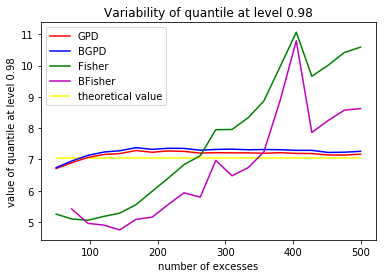

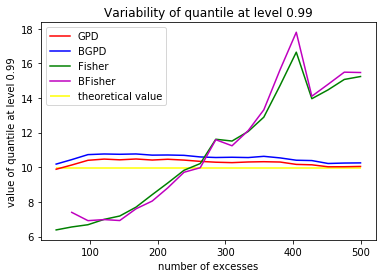

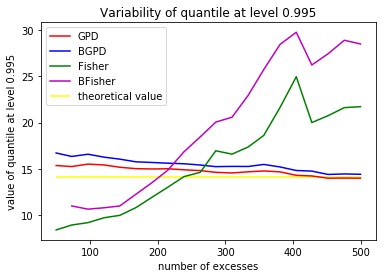

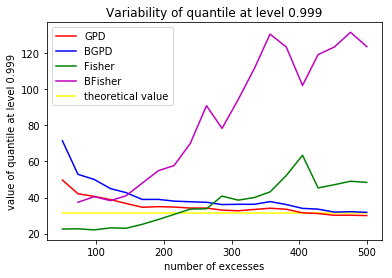

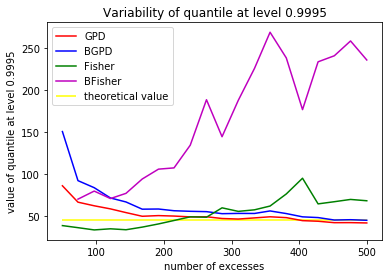

In [34]:
for i in range(len(q)):
    compare_quantiles(jump_excesses,
                  concatenated_averaged_quant_GPD, 
                  concatenated_averaged_bayesian_quant_GPD, 
                  concatenated_averaged_quant_Fisher, 
                      concatenated_averaged_bayesian_quant_Fisher,
                  quant_th,
                  i)

In [17]:
counter = 0 # counter to normalize over the values of parameters
n = 1
for i in range(1,n): 
    counter = counter +  1
print(counter)

0


In [12]:
# concatenated_averaged_quant_Fisher[3, :] 
# str(concatenated_averaged_quant_Fisher[3, :])
# 3 stands for the same level of quantile but for different number of excesses 
# instead of 3 we should be able to use i in 0, 1, 2, 3, 4, those represents different levels of quantiles 